In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('ggplot')

In [5]:
# Read data
df = pd.read_excel('PCA.xlsx')
del df['Event']
df

,Nedbør (mm),Varighet (mins),Flow (m3),Maksimum vannføring (l/min),PAH16EPA (g),STS (kg)
0,3.2,180.000000,22.092854,522.782763,26.199122,1.634972
1,7.4,56.166667,40.407445,158.719437,15.316240,0.955819
2,0.8,8.250000,2.129838,41.726251,0.637603,0.039790
3,2.4,43.958333,9.230749,31.730304,18.200321,1.135802
4,1.2,20.125000,7.963666,38.816686,6.850239,0.427493
5,2.2,28.916667,15.258731,386.085899,13.892321,0.866959
6,4.0,35.875000,36.378883,1142.676408,64.449319,4.021998
7,9.4,55.125000,107.180131,647.153259,19.465345,1.214746
8,7.2,24.000000,91.490499,2569.348040,40.625378,2.535251
9,0.6,6.666667,6.239004,294.537574,0.459460,0.028673


In [3]:
def run_pca(df, cols=None):
    """ Applies PCA and generates summary plots.
    
    Args:
        df      Dataframe of features. Must include "country" and "regulated" 
                columns
        cols    Subset of columns to use
        
    Returns:
        Dataframe of PC loadings. Also generates a range of plots.
    """ 
    if cols:
        df = df[cols].astype(float)

    # Standardise the feature data
    feat_std = StandardScaler().fit_transform(df)

    # Setup PCA. Initially, choose to keep ALL components
    pca = PCA()

    # Fit model
    pca.fit(feat_std)

    # Get explained variances (in %)
    var_exp = 100*pca.explained_variance_ratio_
    cum_exp = np.cumsum(var_exp)

    # Get eigenvalues
    cov_mat = np.cov(feat_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Get number of EVs > 1 (Kaiser-Guttman criterion)
    # and print summary
    n_kgc = (eig_vals > 1).sum()
    print ('Variance explained by first %s PCs (%%):\n' % n_kgc)
    print (var_exp[:n_kgc])
    print ('\nTotal: %.2f%%' % var_exp[:n_kgc].sum())
    
    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    # Explained variance
    axes[0].bar(range(1, len(var_exp)+1), var_exp, 
                align='center', label='Individual components')
    axes[0].plot(range(1, len(cum_exp)+1), cum_exp, 
                 'r-o', label='Cumulative')
    axes[0].set_xlabel('Principal component')
    axes[0].set_ylabel('Variance explained (%)')
    axes[0].legend(loc='center right')
    
    # Eigenvalues
    axes[1].plot(range(1, len(eig_vals)+1), np.sort(eig_vals)[::-1], 
                 'r-o', label='Eigenvalues')
    axes[1].axhline(1, c='k', ls='-', label='Kaiser-Guttman threshold')
    axes[1].set_xlabel('Principal component')
    axes[1].set_ylabel('Eigenvalue')
    axes[1].legend(loc='upper right')  
    
    # PC loadings
    loads = pd.DataFrame(data=pca.components_, 
                         columns=df.columns,
                         index=range(1, pca.components_.shape[0]+1)).T

    # Project into 2 and 3 components
    fig = plt.figure(figsize=(16, 6))
   
    # Plot 2 components
    ax = fig.add_subplot(1, 2, 1)
    
    # Refit the PCA, this time specifying 2 components
    # and transforming the result
    feat_reduced = PCA(n_components=2).fit_transform(feat_std)
    
    # Build df 
    data = pd.DataFrame({'PC1':feat_reduced[:, 0],
                         'PC2':feat_reduced[:, 1]})    
   
    # Plot
    ax.scatter(data['PC1'], data['PC2'], s=60)        
    ax.set_xlabel('First principal component')
    ax.set_ylabel('Second principal component')
    ax.set_title('First two PCA directions')
       
    # Plot 3 components
    ax = fig.add_subplot(1, 2, 2, projection='3d', 
                         elev=-150, azim=135)

    # Refit the PCA, this time specifying 3 components
    # and transforming the result
    feat_reduced = PCA(n_components=3).fit_transform(feat_std)

    # Build df with colours
    data = pd.DataFrame({'PC1':feat_reduced[:, 0],
                         'PC2':feat_reduced[:, 1],
                         'PC3':feat_reduced[:, 2]})   
    
    
    # Plot
    ax.scatter(data['PC1'], data['PC2'], data['PC3'], s=60)        
    ax.set_title('First three PCA directions')
    ax.set_xlabel('First principal component')
    ax.set_ylabel('Second principal component')
    ax.set_zlabel('Third principal component')
    ax.legend(bbox_to_anchor=(0.15, -0.1), frameon=True)
    plt.show()

    return loads

No handles with labels found to put in legend.


Variance explained by first 1 PCs (%):

[77.18961722]

Total: 77.19%


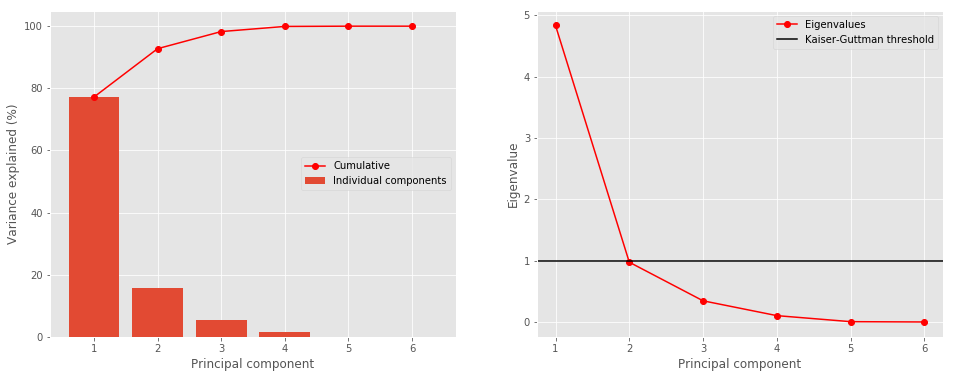

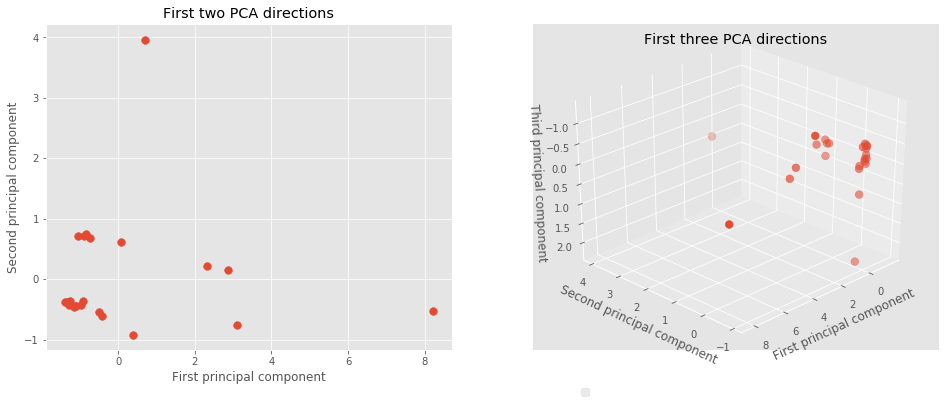

,1,2,3,4,5,6
Nedbør (mm),0.442991,-0.122283,-0.272120,0.722320,0.439331,-0.000017
Varighet (mins),0.147659,0.979203,0.098732,0.071874,0.066645,-0.001575
Flow (m3),0.461574,-0.011206,-0.135538,0.185116,-0.856846,0.000807
Maksimum vannføring (l/min),0.390698,-0.157214,0.903394,0.028076,0.075687,0.001085
PAH16EPA (g),0.456196,-0.024915,-0.202802,-0.468415,0.177621,0.706522
STS (kg),0.456230,-0.027303,-0.201451,-0.467567,0.176308,-0.707688


In [6]:
run_pca(df)